<a href="https://colab.research.google.com/github/dchriscothern/college-guard-tracking-sample/blob/main/college_guard_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📁 Please upload tracking_college_guard_sample.csv


Saving tracking_college_guard_sample.csv to tracking_college_guard_sample.csv

Loaded file: tracking_college_guard_sample.csv
   possession_id  frame  timestamp_ms  ball_x  ball_y  pg_x  pg_y  pg_vx  \
0           12.0  101.0           0.0    47.2    22.1  46.1  21.8    0.4   
1           12.0  102.0          40.0    47.5    22.3  46.4  22.1    0.6   
2           12.0  103.0          80.0    48.1    22.5  46.9  22.6    0.9   
3           12.0  104.0         120.0    49.0    22.9  47.8  23.5    1.2   
4           12.0  105.0         160.0    49.8    23.2  48.9  24.7    1.4   

   pg_vy  def_x  def_y  def_distance  pg_speed  advantage       action_tag  \
0    0.1   47.9   23.4           1.7      0.41        0.0  INIT_POSSESSION   
1    0.3   48.1   23.2           1.6      0.67        0.0          DRIBBLE   
2    0.6   48.4   23.1           1.3      1.08        0.0          DRIBBLE   
3    0.9   48.7   23.0           1.0      1.50        0.0        PNR_START   
4    1.3   49.5   23.6     

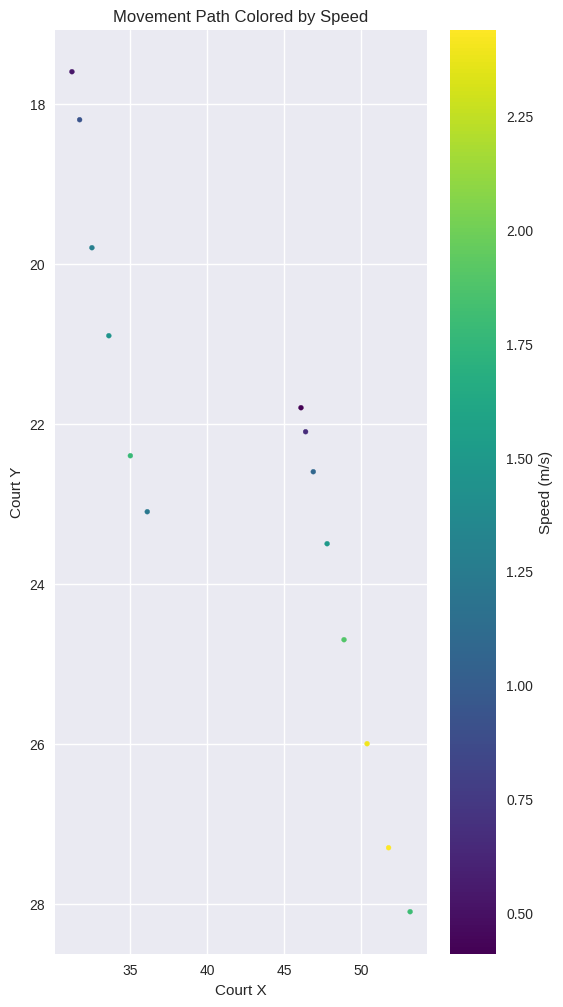

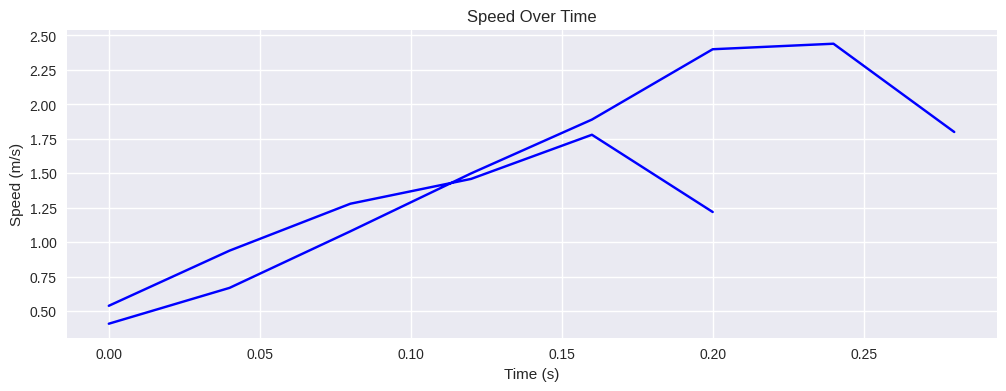

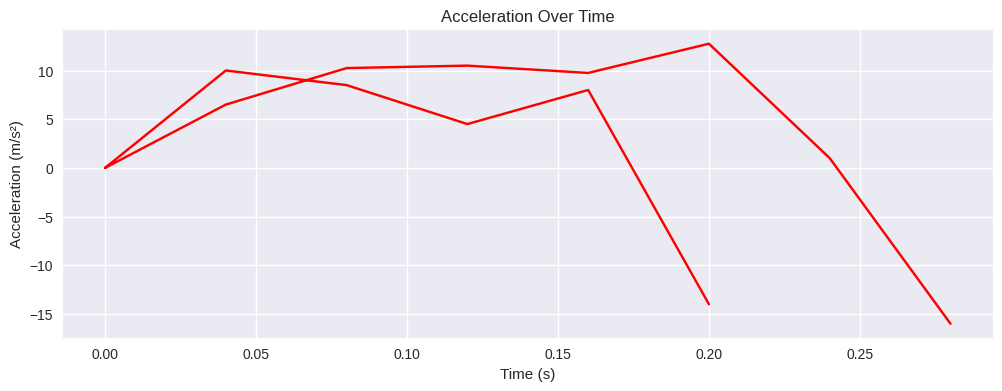

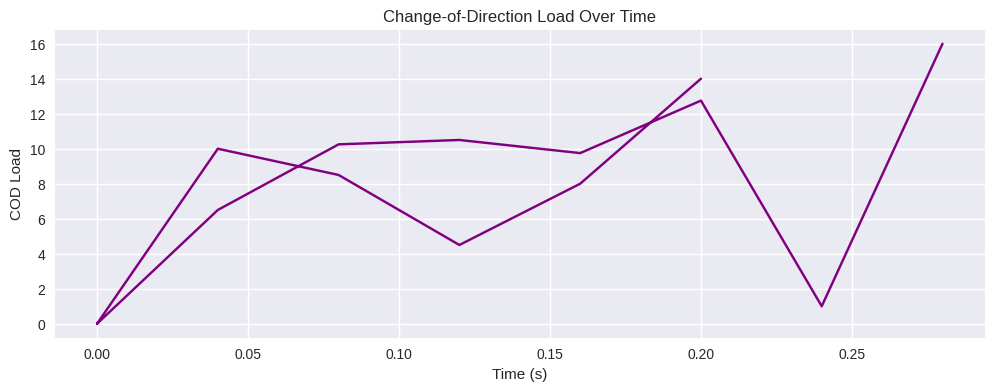

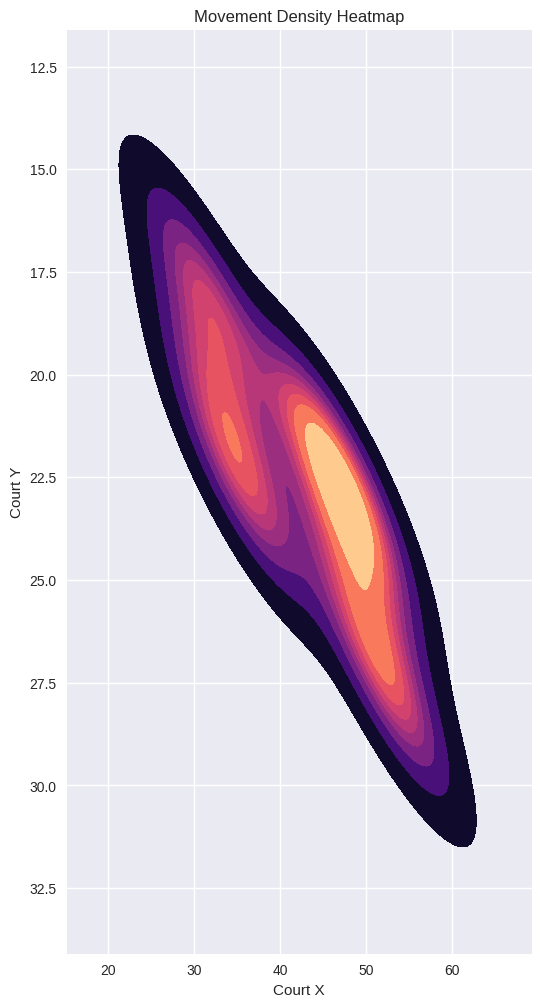

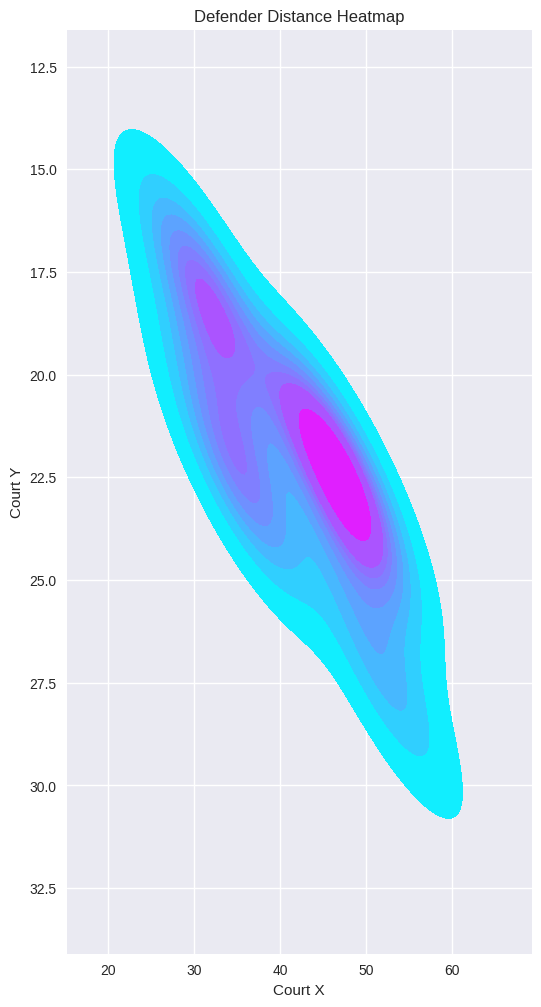

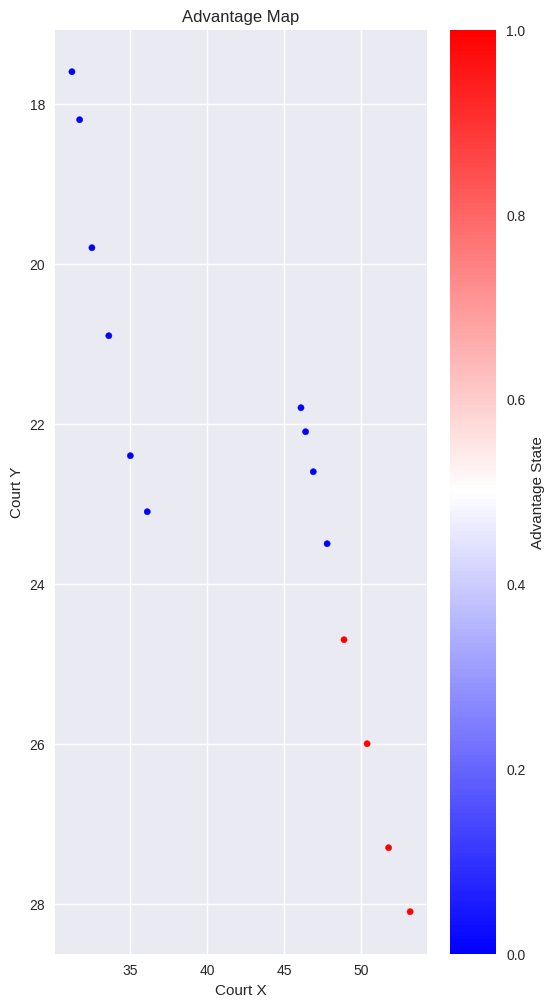

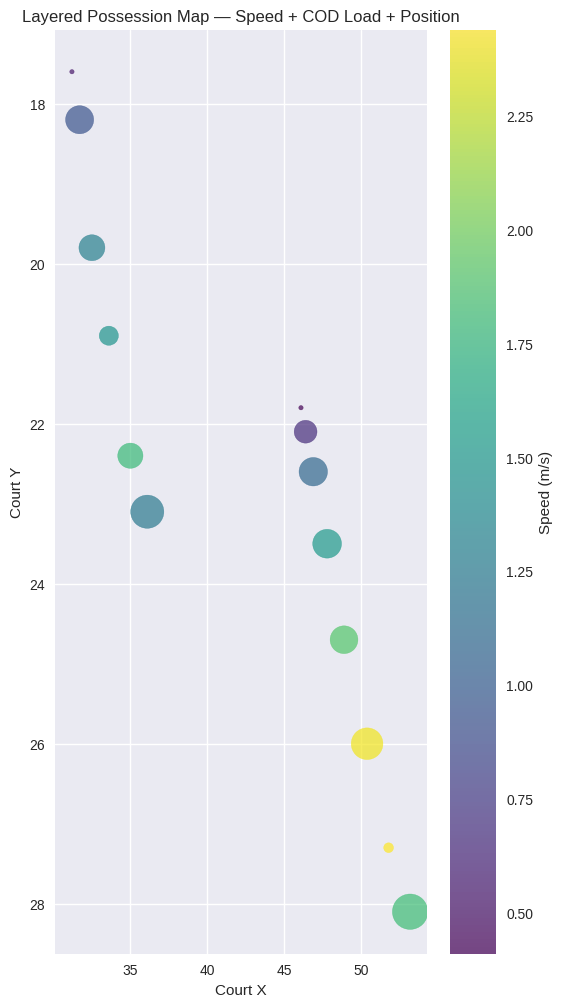


===== KEY INSIGHTS =====

Total distance: 17.02 m
Peak speed: 2.44 m/s
Peak acceleration: 12.75 m/s²
Mean defender distance: 1.11 m

Frames spent in each advantage state:
advantage
0    11
1     4
Name: count, dtype: int64

High-speed efforts: 2

✔ All visuals, heatmaps, and metrics generated successfully.


In [5]:
# ============================================================
# College Guard Tracking Analysis – Portfolio Version
# Author: Chris Cothern, DPT, CSCS, CPSS
# Description:
#   Demonstration of applied basketball tracking analytics using Python.
#   Includes: derived metrics, tracking-style visuals, heatmaps, insights.
# ============================================================

# ----------------------------
# 0. Imports
# ----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

plt.style.use("seaborn-v0_8")

# ============================================================
# 1. DATA IMPORT
# ============================================================

print("📁 Please upload tracking_college_guard_sample.csv")

uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

print("\nLoaded file:", file_name)
print(df.head())

# ============================================================
# 2. DATA CLEANING & TIMESTAMPS
# ============================================================

numeric_cols = [
    "pg_x", "pg_y",
    "pg_vx", "pg_vy",
    "pg_speed",
    "advantage",
    "def_distance"
]

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    else:
        print(f"⚠️ Missing expected column: {col}")

# Create timestamp (critical)
if "timestamp_ms" in df.columns:
    df["timestamp_s"] = df["timestamp_ms"] / 1000.0
else:
    print("⚠️ timestamp_ms not found → creating synthetic 25 fps timeline.")
    df["timestamp_s"] = np.arange(len(df)) * 0.04

# Advantage cannot be int if NaN
df["advantage"] = df["advantage"].fillna(0).astype(int)

# ============================================================
# 3. DERIVED METRICS
# ============================================================

df["computed_speed"] = np.sqrt(df["pg_vx"]**2 + df["pg_vy"]**2)

df["pg_accel"] = df["pg_speed"].diff() / df["timestamp_s"].diff()
df["pg_accel"] = df["pg_accel"].replace([np.inf, -np.inf], np.nan).fillna(0)

df["cod_load"] = df["pg_accel"].abs()

df["dist_traveled"] = np.sqrt(df["pg_x"].diff()**2 + df["pg_y"].diff()**2).fillna(0)

speed_threshold = df["pg_speed"].mean() + df["pg_speed"].std()
df["high_speed_flag"] = df["pg_speed"] > speed_threshold

print("✔ Derived metrics computed.")

# ============================================================
# 4. POSSESSION SUMMARY TABLE
# ============================================================

summary = df.groupby("advantage").agg({
    "pg_speed": ["mean", "max"],
    "pg_accel": ["mean", "max"],
    "cod_load": "mean",
    "dist_traveled": "sum"
})

print("\n===== POSSESSION SUMMARY (by Advantage) =====\n")
print(summary)

# ============================================================
# 5. VISUALIZATION 1 — Movement Path (Tracking Style)
# ============================================================

plt.figure(figsize=(6,12))
plt.scatter(df["pg_x"], df["pg_y"], s=12, c=df["pg_speed"], cmap="viridis")
plt.gca().invert_yaxis()
plt.colorbar(label="Speed (m/s)")
plt.title("Movement Path Colored by Speed")
plt.xlabel("Court X")
plt.ylabel("Court Y")
plt.show()

# ============================================================
# 6. VISUALIZATION 2 — Speed Over Time
# ============================================================

plt.figure(figsize=(12,4))
plt.plot(df["timestamp_s"], df["pg_speed"], label="Speed", color="blue")
plt.title("Speed Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Speed (m/s)")
plt.grid(True)
plt.show()

# ============================================================
# 7. VISUALIZATION 3 — Accel Over Time
# ============================================================

plt.figure(figsize=(12,4))
plt.plot(df["timestamp_s"], df["pg_accel"], label="Acceleration", color="red")
plt.title("Acceleration Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s²)")
plt.grid(True)
plt.show()

# ============================================================
# 8. VISUALIZATION 4 — COD Load Timeline
# ============================================================

plt.figure(figsize=(12,4))
plt.plot(df["timestamp_s"], df["cod_load"], color="purple")
plt.title("Change-of-Direction Load Over Time")
plt.xlabel("Time (s)")
plt.ylabel("COD Load")
plt.grid(True)
plt.show()

# ============================================================
# 9. HEATMAP 1 — Position Density Heatmap
# ============================================================

plt.figure(figsize=(6,12))
sns.kdeplot(
    x=df["pg_x"], y=df["pg_y"],
    fill=True, cmap="magma", thresh=0.05
)
plt.gca().invert_yaxis()
plt.title("Movement Density Heatmap")
plt.xlabel("Court X")
plt.ylabel("Court Y")
plt.show()

# ============================================================
# 10. HEATMAP 2 — Defender Distance Heatmap
# ============================================================

plt.figure(figsize=(6,12))
sns.kdeplot(
    x=df["pg_x"], y=df["pg_y"],
    weights=df["def_distance"],
    cmap="cool", fill=True, thresh=0.05
)
plt.gca().invert_yaxis()
plt.title("Defender Distance Heatmap")
plt.xlabel("Court X")
plt.ylabel("Court Y")
plt.show()

# ============================================================
# 11. HEATMAP 3 — Advantage Map Scatter
# ============================================================

plt.figure(figsize=(6,12))
plt.scatter(
    df["pg_x"], df["pg_y"],
    c=df["advantage"], cmap="bwr", s=20
)
plt.gca().invert_yaxis()
plt.colorbar(label="Advantage State")
plt.title("Advantage Map")
plt.xlabel("Court X")
plt.ylabel("Court Y")
plt.show()

# ============================================================
# 12. LAYERED POSSESSION MAP — Speed + COD + Distance
# ============================================================

fig, ax = plt.subplots(figsize=(6,12))

p = ax.scatter(
    df["pg_x"], df["pg_y"],
    c=df["pg_speed"], cmap="viridis", s=df["cod_load"]*40 + 10, alpha=0.7
)

ax.invert_yaxis()
fig.colorbar(p, label="Speed (m/s)")
ax.set_title("Layered Possession Map — Speed + COD Load + Position")
ax.set_xlabel("Court X")
ax.set_ylabel("Court Y")

plt.show()

# ============================================================
# 13. SUMMARY OUTPUT
# ============================================================

print("\n===== KEY INSIGHTS =====\n")
print(f"Total distance: {df['dist_traveled'].sum():.2f} m")
print(f"Peak speed: {df['pg_speed'].max():.2f} m/s")
print(f"Peak acceleration: {df['pg_accel'].max():.2f} m/s²")
print(f"Mean defender distance: {df['def_distance'].mean():.2f} m\n")

print("Frames spent in each advantage state:")
print(df["advantage"].value_counts().sort_index())

print("\nHigh-speed efforts:", df["high_speed_flag"].sum())
print("\n✔ All visuals, heatmaps, and metrics generated successfully.")
